# lstm_neural_network.ipynb

## Notebook Purpose
This notebook is designed to develop and train an LSTM (Long Short-Term Memory) neural network model for predicting cryptocurrency prices. The trained LSTM model will be used to generate future price predictions.

## Instructions
1. **Import Necessary Libraries**:
   - Import `pandas` and `numpy` for data manipulation.
   - Import `MinMaxScaler` from `sklearn.preprocessing` for feature scaling.
   - Import necessary modules from `tensorflow.keras` for building the LSTM model.

2. **Load Preprocessed Data**:
   - Load the preprocessed CSV file created in the first notebook.

3. **Prepare Data for LSTM**:
   - Scale the data using `MinMaxScaler`.
   - Create sequences of data for LSTM input.

4. **Build and Train LSTM Model**:
   - Define the LSTM model architecture.
   - Compile and train the model using the prepared data.

5. **Save the Trained Model**:
   - Save the trained LSTM model to a file for later use.

6. **Evaluate Model Performance**:
   - Evaluate the model's performance using appropriate metrics.

## Example Code
```python
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib

# Load preprocessed data
data_path = 'data/historical_data/btc_usd_preprocessed.csv'  # Update this path based on the selected cryptocurrency
data = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')

# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length), 0]
        y = data[i + seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

X_train, X_test = X[:int(len(X) * 0.8)], X[int(len(X) * 0.8):]
y_train, y_test = y[:int(len(y) * 0.8)], y[int(len(y) * 0.8):]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Save the model
model.save('models/lstm_model.h5')
joblib.dump(scaler, 'models/scaler.pkl')

# Evaluate model performance
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss:.4f}')
print(f'Test Loss: {test_loss:.4f}')


In [1]:
# Cell 1: Import necessary libraries
try:
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    import matplotlib.pyplot as plt
    import joblib
    import os
    print("Libraries imported successfully.")
except ImportError as e:
    print(f"Error importing libraries: {e}")


Libraries imported successfully.


In [2]:
# Cell 2: Load preprocessed data
data_paths = {
    'BTC': '../data/cleaned_data/BTC_cleaned.csv',
    'ETH': '../data/cleaned_data/ETH_cleaned.csv',
    'SOL': '../data/cleaned_data/SOL_cleaned.csv'
}

crypto_data = {crypto: pd.read_csv(path, parse_dates=['Date'], index_col='Date') for crypto, path in data_paths.items()}

# Verify loaded data
for crypto, data in crypto_data.items():
    print(f"Columns in {crypto} data: {data.columns}")
    print(f"First few rows of {crypto} data:\n{data.head()}")


Columns in BTC data: Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
First few rows of BTC data:
             Open    High    Low  Close      Volume
Date                                               
2013-07-10  76.70   89.84  75.53  88.00  4916740.89
2013-07-11  88.00   90.70  85.00  88.98  3084484.64
2013-07-12  88.98  104.17  88.00  93.99  9759561.48
2013-07-13  93.99   98.32  87.76  98.32  3186590.74
2013-07-14  98.32   99.00  92.86  94.42  1171458.48
Columns in ETH data: Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
First few rows of ETH data:
              Open     High     Low   Close     Volume
Date                                                  
2013-07-10  0.0000   0.0000  0.0000  0.0000       0.00
2015-08-07  0.7812  27.7900  0.7809  2.7730  148608.32
2015-08-08  2.7730   2.5810  0.5958  0.8076  583543.48
2015-08-09  0.8076   0.9581  0.6043  0.7428  547528.03
2015-08-10  0.7428   0.7628  0.5990  0.6846  401107.09
Columns in SOL data: 

In [3]:
# Cell 3: Prepare data for LSTM
def prepare_lstm_data(data, sequence_length=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

crypto_lstm_data = {crypto: prepare_lstm_data(data) for crypto, data in crypto_data.items()}

# Verify prepared data
for crypto, (X, y, scaler) in crypto_lstm_data.items():
    print(f"{crypto} LSTM data shape: X={X.shape}, y={y.shape}")


BTC LSTM data shape: X=(3950, 60, 1), y=(3950,)
ETH LSTM data shape: X=(3193, 60, 1), y=(3193,)
SOL LSTM data shape: X=(1485, 60, 1), y=(1485,)


In [4]:
# Cell 4: Split data into training and testing sets
def split_data(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    print(f"Data split: X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")
    return X_train, X_test, y_train, y_test

crypto_splits = {crypto: split_data(X, y) for crypto, (X, y, scaler) in crypto_lstm_data.items()}

# Verify data splits
for crypto, (X_train, X_test, y_train, y_test) in crypto_splits.items():
    print(f"\n{crypto} data split:")
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


Data split: X_train shape: (3160, 60, 1), X_test shape: (790, 60, 1), y_train shape: (3160,), y_test shape: (790,)
Data split: X_train shape: (2554, 60, 1), X_test shape: (639, 60, 1), y_train shape: (2554,), y_test shape: (639,)
Data split: X_train shape: (1188, 60, 1), X_test shape: (297, 60, 1), y_train shape: (1188,), y_test shape: (297,)

BTC data split:
X_train shape: (3160, 60, 1), X_test shape: (790, 60, 1)
y_train shape: (3160,), y_test shape: (790,)

ETH data split:
X_train shape: (2554, 60, 1), X_test shape: (639, 60, 1)
y_train shape: (2554,), y_test shape: (639,)

SOL data split:
X_train shape: (1188, 60, 1), X_test shape: (297, 60, 1)
y_train shape: (1188,), y_test shape: (297,)


In [5]:
# Cell 5: Build and train the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

crypto_models = {}
for crypto, (X_train, X_test, y_train, y_test) in crypto_splits.items():
    print(f"Building and training LSTM model for {crypto}")
    model = build_lstm_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    crypto_models[crypto] = model

# Verify trained models
for crypto, model in crypto_models.items():
    print(f"{crypto} LSTM model trained successfully.")


Building and training LSTM model for BTC
Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0216 - val_loss: 5.6404e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.2497e-04 - val_loss: 5.8363e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.2519e-04 - val_loss: 4.6365e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.7071e-04 - val_loss: 4.2536e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.5346e-04 - val_loss: 4.9132e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.1511e-04 - val_loss: 4.6663e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.7931e-04 - val_loss: 5.6440e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.5976e-04 - val_loss: 2.9264e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.1092e-04 - val_loss: 2.9331e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.8284e-04 - val_loss: 2.4272e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.6486e-04 - val_loss: 2

In [6]:
# Cell 6: Save the trained models
for crypto, model in crypto_models.items():
    model.save(f'../models/{crypto}_lstm_model.h5')
    print(f"{crypto} model saved to ../models/{crypto}_lstm_model.h5")


BTC model saved to ../models/BTC_lstm_model.h5
ETH model saved to ../models/ETH_lstm_model.h5
SOL model saved to ../models/SOL_lstm_model.h5


In [7]:
# Cell 7: Evaluate model performance
for crypto, (X_train, X_test, y_train, y_test) in crypto_splits.items():
    model = crypto_models[crypto]
    predictions = model.predict(X_test)
    mse = np.mean(np.square(predictions - y_test))
    print(f"{crypto} model - MSE: {mse}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
BTC model - MSE: 0.11924989416148067
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
ETH model - MSE: 0.11369900170071828
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
SOL model - MSE: 0.0971256293841847


In [8]:
# Cell 8: Predict future prices
def predict_future_prices(model, scaled_data, num_predictions=30, seq_length=60):
    last_sequence = scaled_data[-seq_length:].reshape(1, seq_length, 1)
    future_predictions = []

    for _ in range(num_predictions):
        next_price = model.predict(last_sequence)
        future_predictions.append(next_price[0, 0])
        # Reshape next_price to match last_sequence dimensions
        next_price_reshaped = next_price.reshape(1, 1, 1)
        last_sequence = np.append(last_sequence[:, 1:, :], next_price_reshaped, axis=1)

    return future_predictions

# Predict future prices for each cryptocurrency
crypto_future_predictions = {}
for crypto, model in crypto_models.items():
    _, _, scaler = crypto_lstm_data[crypto]
    scaled_data = scaler.transform(crypto_data[crypto]['Close'].values.reshape(-1, 1))
    future_predictions = predict_future_prices(model, scaled_data)
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    crypto_future_predictions[crypto] = future_predictions
    print(f"{crypto} future predictions generated.")

# Verify future predictions
for crypto, future_predictions in crypto_future_predictions.items():
    print(f"\n{crypto} future predictions:")
    print(future_predictions[:5])  # Print first 5 predictions for verification


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/ste

/var/folders/wq/yrwdfvsn52l4zzjxfytvq8300000gn/T/ipykernel_83986/654682736.py:5: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(start=last_date, periods=len(future_predictions) + 1, closed='right')


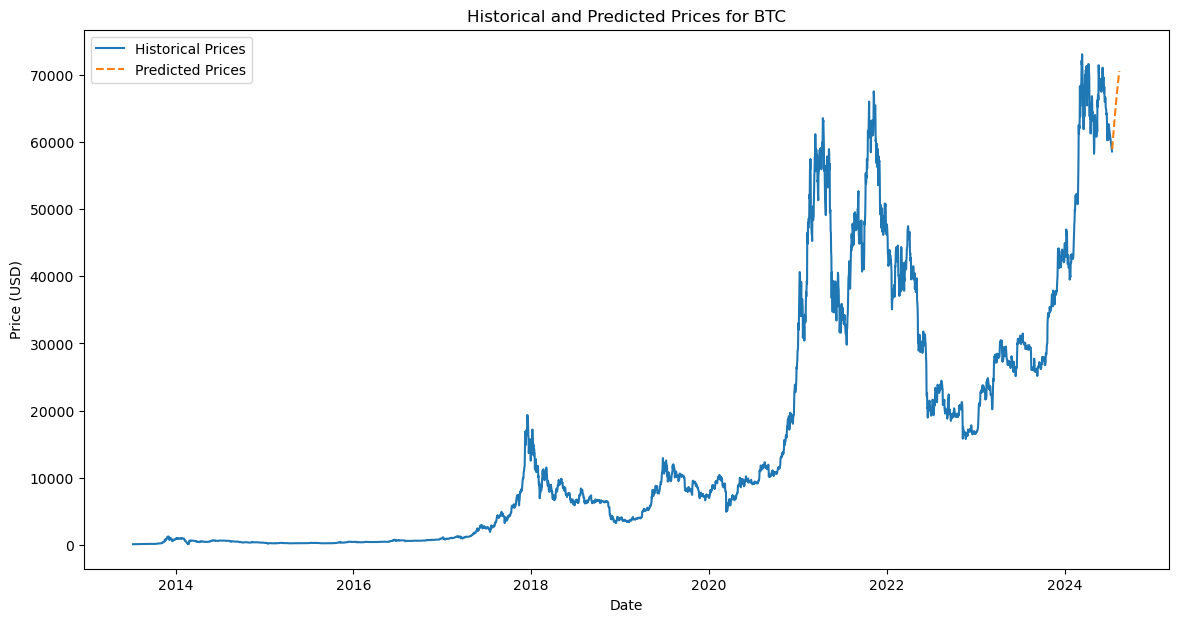

Future predictions for BTC saved to ../results/output_predictions/BTC_future_predictions.csv


/var/folders/wq/yrwdfvsn52l4zzjxfytvq8300000gn/T/ipykernel_83986/654682736.py:5: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(start=last_date, periods=len(future_predictions) + 1, closed='right')


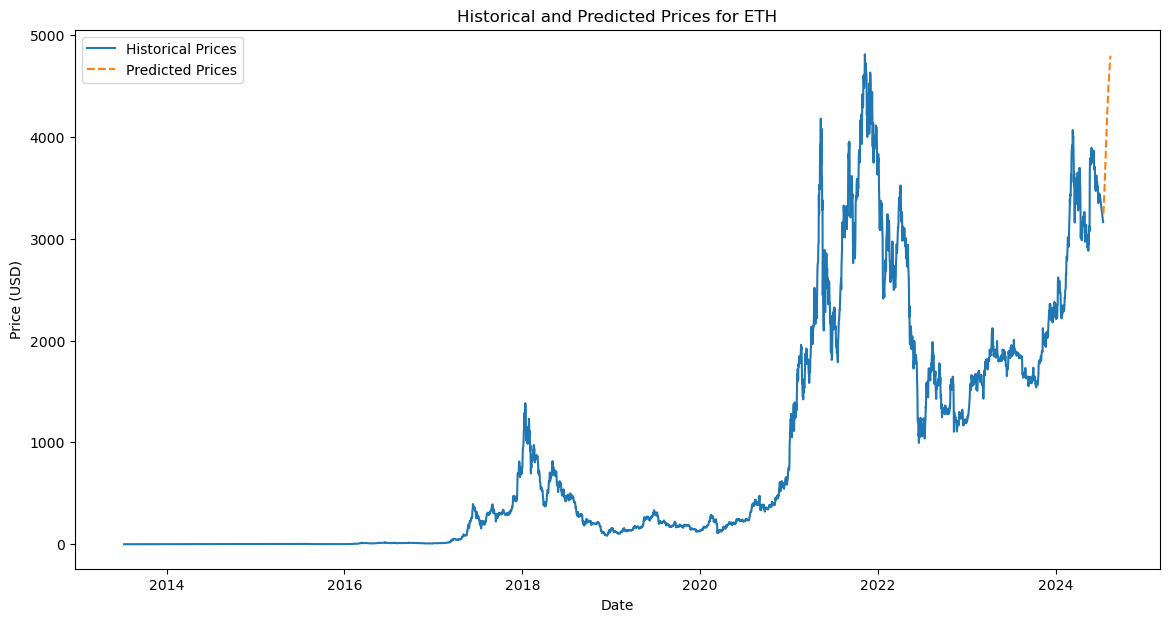

Future predictions for ETH saved to ../results/output_predictions/ETH_future_predictions.csv


/var/folders/wq/yrwdfvsn52l4zzjxfytvq8300000gn/T/ipykernel_83986/654682736.py:5: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(start=last_date, periods=len(future_predictions) + 1, closed='right')


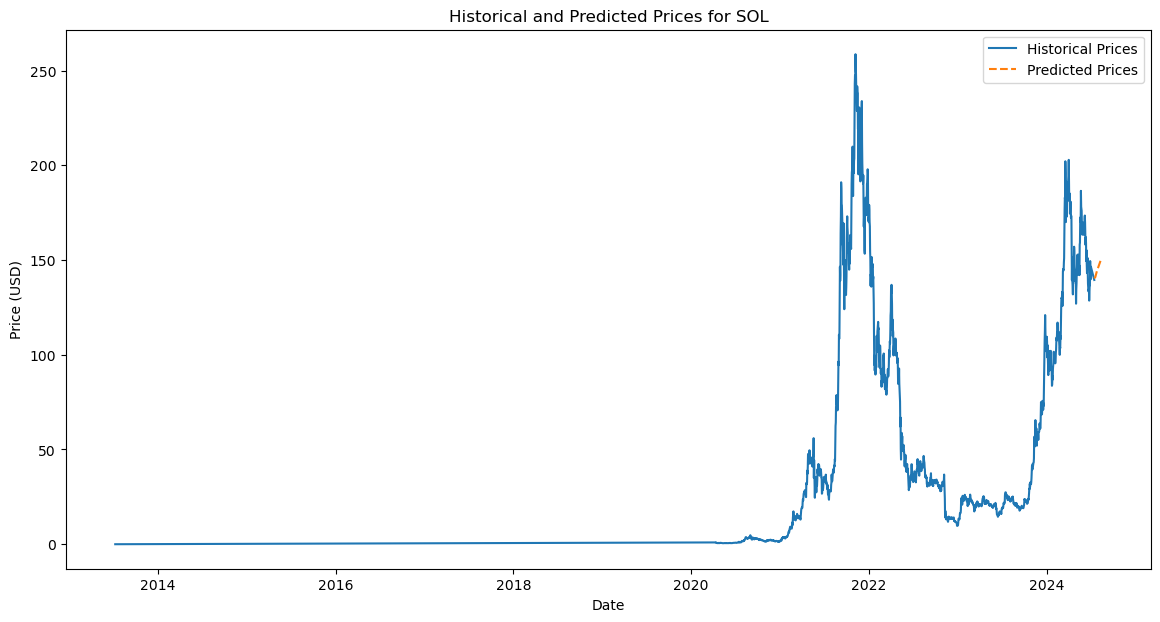

Future predictions for SOL saved to ../results/output_predictions/SOL_future_predictions.csv


In [9]:
# Cell 9: Plotting historical and predicted prices
for crypto, future_predictions in crypto_future_predictions.items():
    data = crypto_data[crypto]
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date, periods=len(future_predictions) + 1, closed='right')
    
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Historical Prices')
    plt.plot(future_dates, future_predictions, label='Predicted Prices', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.title(f'Historical and Predicted Prices for {crypto}')
    plt.legend()
    plt.show()
    
    output_path = f'../results/output_predictions/{crypto}_future_predictions.csv'
    future_predictions_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted Price': future_predictions.flatten()
    })
    future_predictions_df.to_csv(output_path, index=False)
    print(f"Future predictions for {crypto} saved to {output_path}")
